<p align="center">
<img alt="logo" src="https://upload.wikimedia.org/wikipedia/ar/thumb/1/16/Birzeit_University_logo.svg/320px-Birzeit_University_logo.svg.png"/>
<br>
Faculty of Engineering and Technology<br>
Electrical and Computer Engineering Department<br></p>
<hr>
<hr>
<p align="center">
ENCS5343 Computer Vision<br>
<br>
<b>Course Project</b><br>
<b>Arabic Handwritten Character Recognition (AHCR)</b><br>
<br>
Student Name: Maysam Khatib<br>
Student ID: 1190207<br>
Student Name: Ameer Zedany<br>
Student ID: 1190482
</p>
<hr>

# **Introduction**

# **Tasks**

## **Import Libraries**

In [1]:
!pip install gdown
!pip install numpy==1.23.0

  Obtaining dependency information for gdown from https://files.pythonhosted.org/packages/9e/db/c5dad38733f0995dea4480de38df1b3f6222b77b0dc89aad2402d86e2ff4/gdown-5.0.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 52.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 11.0.0 which is incomp

In [2]:
# Import needed library in the project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Libraries to deal with the dataset
import os # for dealing with files and directories (used to download the dataset)
from zipfile import ZipFile # to unzip the dataset zipped file
import gdown
import random # to get random images to display
# Tensorflow
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import GridSearchCV ,train_test_split
from sklearn.base import clone
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras import layers, models
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout ,Input
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## **Dataset**

### **Download Dataset**

In [3]:
# download the dataset from the link
file_id = '1ZQ8fSD6WgkXFBKIxMRBMn0-gTwzFjUvz'
download_link = f'https://drive.google.com/u/0/uc?id={file_id}'
zip_file_name = 'project_dataset.zip'

# check if the dataset folder is existed (to not download it again)
dataset_folder_name = 'dataset'
if not os.path.exists(dataset_folder_name) or not any(os.scandir(dataset_folder_name)):

  # check if the zip file is existed
  if not os.path.exists(zip_file_name):
    with open(zip_file_name, 'wb') as zip_file:
      gdown.download(download_link, zip_file_name, quiet=False)

  # make the dataset folder
  os.makedirs(dataset_folder_name, exist_ok=True)

  # unzip the zipped file
  with ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(dataset_folder_name)

  # Remove the zipped file after extraction
  os.remove(zip_file_name)
else:
    print("Dataset is already existed")

Downloading...
From: https://drive.google.com/u/0/uc?id=1ZQ8fSD6WgkXFBKIxMRBMn0-gTwzFjUvz
To: /kaggle/working/project_dataset.zip
100%|██████████| 25.2M/25.2M [00:01<00:00, 22.1MB/s]


### **Discover Dataset Content**

In [4]:
print("Contents of the dataset folder:")
for item in os.listdir(dataset_folder_name):
    print(item)

Contents of the dataset folder:
csvTrainLabel 13440x1.csv
train images 13440x32x32
Train+Test Images Matlab.mat
Test Images 3360x32x32
test images 3360x32x32
arabic handwritten characters dataset csv
csvTestLabel 3360x1.csv
csvTrainImages 13440x1024.csv
Train Images 13440x32x32
Arabic Handwritten Characters Dataset CSV
csvTestImages 3360x1024.csv


### **Data Loading and Preprocessing**

In [5]:
# load the train lables and put them in one dimensional array
train_labels_path = f'{dataset_folder_name}/csvTrainLabel 13440x1.csv'
train_labels = pd.read_csv(train_labels_path, header=None).to_numpy().reshape(-1)
train_labels = train_labels - 1

# load the test lables and put them in one dimensional array
test_labels_path = f'{dataset_folder_name}/csvTestLabel 3360x1.csv'
test_labels = pd.read_csv(test_labels_path, header=None).to_numpy().reshape(-1)
test_labels = test_labels - 1

# load the train images and put them in 4 dimensional array (images with 32x32 pixels and a single grayscale channel)
train_images_path = f'{dataset_folder_name}/csvTrainImages 13440x1024.csv'
train_images = pd.read_csv(train_images_path, header=None).to_numpy().reshape(-1, 32, 32, 1)
train_images = train_images / 255.0 # normalize

# load the test images in 4 dimensional array (images with 32x32 pixels and a single grayscale channel)
test_images_path = f'{dataset_folder_name}/csvTestImages 3360x1024.csv'
test_images = pd.read_csv(test_images_path, header=None).to_numpy().reshape(-1, 32, 32, 1)
test_images = test_images / 255.0 # normalize

### **Prining Data Information**

In [6]:
# print some dataset information
print('*************************************')
print('Training set:')
print('Number of samples:', train_images.shape[0])
print('Number of features (pixels):', train_images.shape[1] * train_images.shape[2])
print('Image shape:', train_images.shape[1:])
print('Number of classes:', len(np.unique(train_labels)))

print('\n*************************************')
print('Testing set:')
print('Number of samples:', test_images.shape[0])
print('Number of features (pixels):', test_images.shape[1] * test_images.shape[2])
print('Image shape:', test_images.shape[1:])
print('Number of classes:', len(np.unique(test_labels)))


*************************************
Training set:
Number of samples: 13440
Number of features (pixels): 1024
Image shape: (32, 32, 1)
Number of classes: 28

*************************************
Testing set:
Number of samples: 3360
Number of features (pixels): 1024
Image shape: (32, 32, 1)
Number of classes: 28


### **Display Random Training Images**

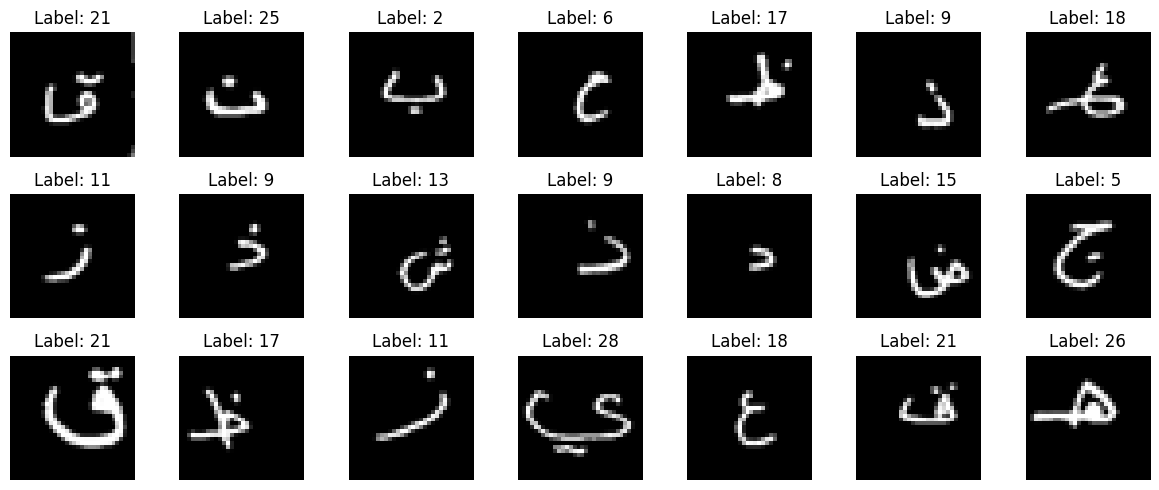

In [7]:
# choose 8 random images from the training dataset
random_indices = np.random.choice(train_images.shape[0], 21, replace=False)

fig, axes = plt.subplots(3, 7, figsize=(12, 5))

# plot the images with their labels
for i, ax in enumerate(axes.flat):
    image = train_images[random_indices[i]]
    image = np.rot90(image, axes=(0, 1))
    label = train_labels[random_indices[i]]
    ax.imshow(image, cmap='gray', origin='lower')
    ax.set_title(f"Label: {label+1}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## **Plotting Function**


In [8]:
def plotAccuracyLossVsEpochs(history):

  training_metrics = [history.history['accuracy'], history.history['loss']]
  testing_metrics =  [history.history['val_accuracy'], history.history['val_loss']]
  titles = ['Accuracy', 'Loss']

  plt.figure(figsize=(12, 5))

  for i in range(0, 2):
    plt.subplot(1, 2, i+1)
    plt.plot(training_metrics[i])
    plt.plot(testing_metrics[i])
    plt.title(f'{titles[i]} vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(titles[i])
    plt.legend(['Train', 'Validation'], loc='upper left')

  plt.tight_layout()
  plt.show()

## **Task 1**


Build and train a custom CNN network for AHCR. To build a custom CNN, you need to define the following:

● Architecture:
*   Number of layers: The depth of the network, typically starting with 1 to 2 convolutional layers and gradually increasing for more complex tasks.
*   Types of layers: convolutional layers, pooling layers (max, average, global), fully connected layers, and potentially other specialized layers (e.g., dropout, batch normalization).
*   Activation functions: ReLU (common choice), sigmoid, tanh, or others for specific needs.

● Convolutional Layer Parameters:
* Number of filters: controls the number of feature maps extracted at each layer. More filters can capture more features but increase computational costs.
* Filter size: determines the receptive field of the filters, often starting with 3x3 or 5x5 and increasing in deeper layers.
* Stride: The step size of the filter movement affects the output size and computational complexity.
* Padding: zero-padding input images to preserve spatial dimensions and capture edge features.

● Pooling Layer Parameters:
* Pool size: The size of the pooling window, common choices being 2x2 or 3x3.
* Pool type: max pooling or average pooling, each with different effects on feature preservation.

● Fully Connected Layer Parameters:
* Number of neurons: related to the complexity of the task and the number of classes for classification.

● Training Hyperparameters:
* Learning rate: controls how much the model's weights are updated during training.
* Batch size: the number of samples processed per training step, affecting gradient updates and convergence speed.
* Epochs: The number of times the model trains on the entire dataset.
* Optimizer: algorithm for updating model weights (e.g., Adam, SGD, RMSprop).
* Overfitting Handling: Techniques to prevent overfitting (e.g., dropout, L1/L2
regularization).

### **Build AHCR CNN Model**

In [9]:
def build_ahcr_cnn_model():

  # initialize the model
  model = models.Sequential()

  # create the layers
  layer1_conv = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 1))
  layer2_pool = layers.MaxPooling2D(pool_size=(2, 2))

  layer3_conv = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='tanh')
  layer4_pool = layers.MaxPooling2D(pool_size=(2, 2))

  layer5_dropout = layers.Dropout(0.25)

  layer6_flat = layers.Flatten()

  layer7_fc = layers.Dense(units=64, activation='relu')
  layer8_dropout = layers.Dropout(0.5)

  layer9_fc_out = layers.Dense(units=28, activation='softmax')

  # add the layers to the model
  model.add(layer1_conv)
  model.add(layer2_pool)
  model.add(layer3_conv)
  model.add(layer4_pool)
  model.add(layer5_dropout)
  model.add(layer6_flat)
  model.add(layer7_fc)
  model.add(layer8_dropout)
  model.add(layer9_fc_out)

  # combile the model
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [10]:
ahcr_model = build_ahcr_cnn_model()

ahcr_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 6, 6, 64)          0         
                                                                 
 flatten (Flatten)           (None, 2304)              0

In [11]:
history = ahcr_model.fit(train_images, train_labels, epochs=25, batch_size=512, validation_data=(test_images, test_labels))

Epoch 1/25


2024-01-27 15:11:04.140234: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


27/27 [==============================] - 4s 25ms/step - loss: 3.0995 - accuracy: 0.1115 - val_loss: 2.6233 - val_accuracy: 0.2991
Epoch 2/25
27/27 [==============================] - 0s 10ms/step - loss: 2.5926 - accuracy: 0.2370 - val_loss: 2.0407 - val_accuracy: 0.4470
Epoch 3/25
27/27 [==============================] - 0s 10ms/step - loss: 2.1678 - accuracy: 0.3379 - val_loss: 1.5791 - val_accuracy: 0.5557
Epoch 4/25
27/27 [==============================] - 0s 10ms/step - loss: 1.8441 - accuracy: 0.4209 - val_loss: 1.3002 - val_accuracy: 0.6405
Epoch 5/25
27/27 [==============================] - 0s 10ms/step - loss: 1.5996 - accuracy: 0.4879 - val_loss: 1.1019 - val_accuracy: 0.6905
Epoch 6/25
27/27 [==============================] - 0s 11ms/step - loss: 1.4300 - accuracy: 0.5325 - val_loss: 0.9470 - val_accuracy: 0.7315
Epoch 7/25
27/27 [==============================] - 0s 11ms/step - loss: 1.2940 - accuracy: 0.5762 - val_loss: 0.8581 - val_accuracy: 0.7521
Epoch 8/25
27/27 [======

105/105 [==============================] - 0s 2ms/step - loss: 0.3849 - accuracy: 0.8908
Test Accuracy: 0.8907738327980042
Test Loss: 0.38490015268325806


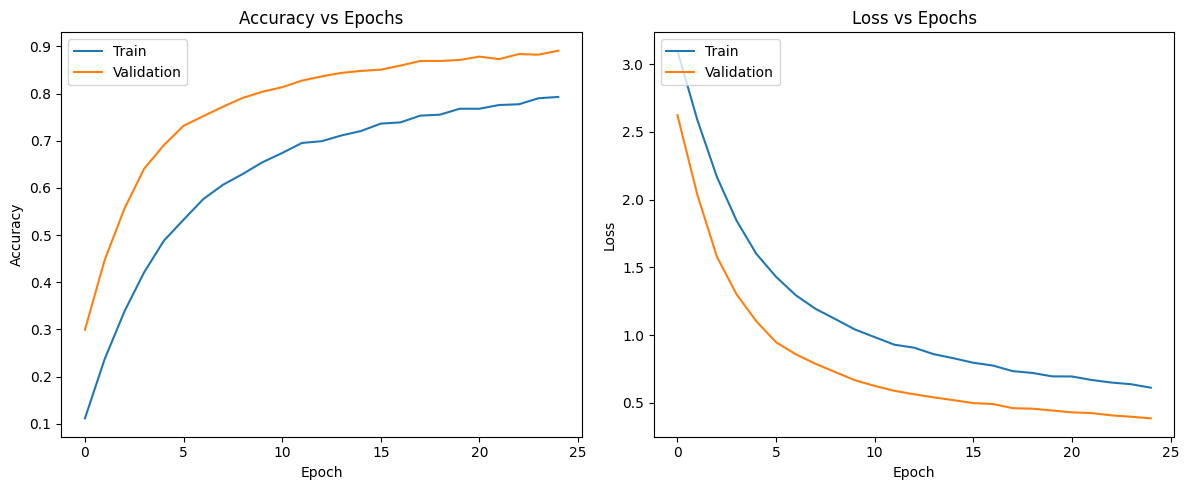

In [12]:
# evaluating the test set on the model
test_loss, test_accuracy = ahcr_model.evaluate(test_images, test_labels)
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Loss: {test_loss}')

plotAccuracyLossVsEpochs(history=history)

## **Task 2**


Retrain the network selected from Task 1 after doing data augmentation.
Data augmentation is a powerful technique for enhancing the diversity and the size of your training data without the need for additional data collection. By applying various transformations to existing data points, you can train models that generalize better to unseen examples and improve their overall performance.

Data augmentation encompasses a wide range of techniques, only a subset of which are suitable for training the AHCR system. In this task, you must select at least three data augmentation techniques that are appropriate and for the model you trained, you need to plot the following:

1. Training loss vs. epoch.
2. Validation loss vs. epoch.
3. Training accuracy vs. epoch.
4. Testing accuracy vs. epoch.

Compare the results you obtained with the results of Task 1.

In [13]:
datagen = ImageDataGenerator(
    rotation_range=15,  # Random rotations
    width_shift_range=0.15,  # Horizontal shifts
    height_shift_range=0.15,  # Vertical shifts
    shear_range=0.2,  # Shearing transformations
    zoom_range=0.2  # Zooming
) #91.7

'''datagen = ImageDataGenerator(
    rotation_range=20,  # Random rotations
    width_shift_range=0.2,  # Horizontal shifts
    height_shift_range=0.2,  # Vertical shifts
    shear_range=0.2,  # Shearing transformations
    zoom_range=0.2  # Zooming
) #88.8

datagen = ImageDataGenerator(
    rotation_range=5,  # Random rotations in the range of 15 degrees
    width_shift_range=0.03,  # Random horizontal shifts in the range of 10% of total width
    height_shift_range=0.03,  # Random vertical shifts in the range of 10% of total height
    horizontal_flip=True  # Randomly flip images horizontally
) #87.9'''

'datagen = ImageDataGenerator(\n    rotation_range=20,  # Random rotations\n    width_shift_range=0.2,  # Horizontal shifts\n    height_shift_range=0.2,  # Vertical shifts\n    shear_range=0.2,  # Shearing transformations\n    zoom_range=0.2  # Zooming\n) #88.8\n\ndatagen = ImageDataGenerator(\n    rotation_range=5,  # Random rotations in the range of 15 degrees\n    width_shift_range=0.03,  # Random horizontal shifts in the range of 10% of total width\n    height_shift_range=0.03,  # Random vertical shifts in the range of 10% of total height\n    horizontal_flip=True  # Randomly flip images horizontally\n) #87.9'

In [14]:
ahcr_model_aug = build_ahcr_cnn_model()
history_aug = ahcr_model_aug.fit(datagen.flow(train_images, train_labels, batch_size=512), epochs=25, validation_data=(test_images, test_labels))

Epoch 1/25


2024-01-27 15:11:16.708770: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


27/27 [==============================] - 6s 165ms/step - loss: 3.2725 - accuracy: 0.0572 - val_loss: 3.0093 - val_accuracy: 0.1667
Epoch 2/25
27/27 [==============================] - 5s 170ms/step - loss: 3.0990 - accuracy: 0.1092 - val_loss: 2.5950 - val_accuracy: 0.2688
Epoch 3/25
27/27 [==============================] - 5s 171ms/step - loss: 2.8726 - accuracy: 0.1589 - val_loss: 2.1924 - val_accuracy: 0.4068
Epoch 4/25
27/27 [==============================] - 4s 164ms/step - loss: 2.6561 - accuracy: 0.2045 - val_loss: 1.8964 - val_accuracy: 0.4976
Epoch 5/25
27/27 [==============================] - 4s 164ms/step - loss: 2.4375 - accuracy: 0.2575 - val_loss: 1.6327 - val_accuracy: 0.5693
Epoch 6/25
27/27 [==============================] - 5s 167ms/step - loss: 2.2885 - accuracy: 0.2871 - val_loss: 1.4369 - val_accuracy: 0.6137
Epoch 7/25
27/27 [==============================] - 4s 165ms/step - loss: 2.1466 - accuracy: 0.3266 - val_loss: 1.2874 - val_accuracy: 0.6497
Epoch 8/25
27/27 

105/105 [==============================] - 0s 2ms/step - loss: 0.6300 - accuracy: 0.7902
Test Accuracy: 0.7901785969734192
Test Loss: 0.6299681067466736


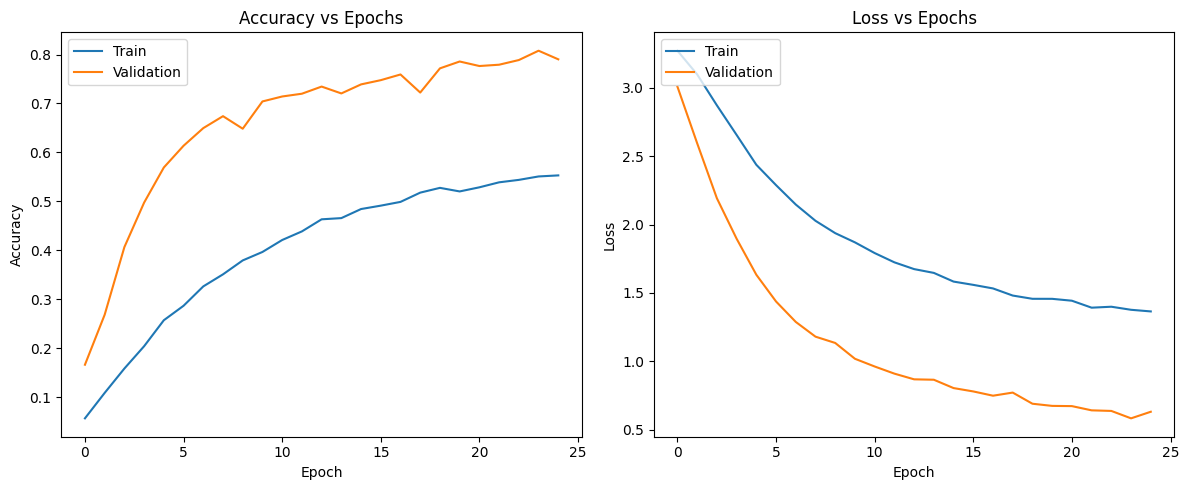

In [15]:
# evaluating the test set on the model
test_loss, test_accuracy = ahcr_model_aug.evaluate(test_images, test_labels)
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Loss: {test_loss}')

plotAccuracyLossVsEpochs(history=history_aug)

In [16]:
ahcr_model_aug = build_ahcr_cnn_model()
history_aug = ahcr_model_aug.fit(datagen.flow(train_images, train_labels, batch_size=512), epochs=100, validation_data=(test_images, test_labels))

Epoch 1/100


2024-01-27 15:13:12.778493: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


27/27 [==============================] - 6s 165ms/step - loss: 3.2538 - accuracy: 0.0654 - val_loss: 2.9278 - val_accuracy: 0.1768
Epoch 2/100
27/27 [==============================] - 4s 164ms/step - loss: 3.0761 - accuracy: 0.1073 - val_loss: 2.5938 - val_accuracy: 0.3003
Epoch 3/100
27/27 [==============================] - 4s 163ms/step - loss: 2.8887 - accuracy: 0.1513 - val_loss: 2.2477 - val_accuracy: 0.4250
Epoch 4/100
27/27 [==============================] - 4s 166ms/step - loss: 2.6666 - accuracy: 0.1972 - val_loss: 1.8443 - val_accuracy: 0.5188
Epoch 5/100
27/27 [==============================] - 4s 162ms/step - loss: 2.4390 - accuracy: 0.2513 - val_loss: 1.5889 - val_accuracy: 0.5679
Epoch 6/100
27/27 [==============================] - 4s 163ms/step - loss: 2.2578 - accuracy: 0.2924 - val_loss: 1.3853 - val_accuracy: 0.6170
Epoch 7/100
27/27 [==============================] - 4s 162ms/step - loss: 2.0996 - accuracy: 0.3278 - val_loss: 1.2857 - val_accuracy: 0.6438
Epoch 8/100

105/105 [==============================] - 0s 2ms/step - loss: 0.2605 - accuracy: 0.9202
Test Accuracy: 0.9202380776405334
Test Loss: 0.26054513454437256


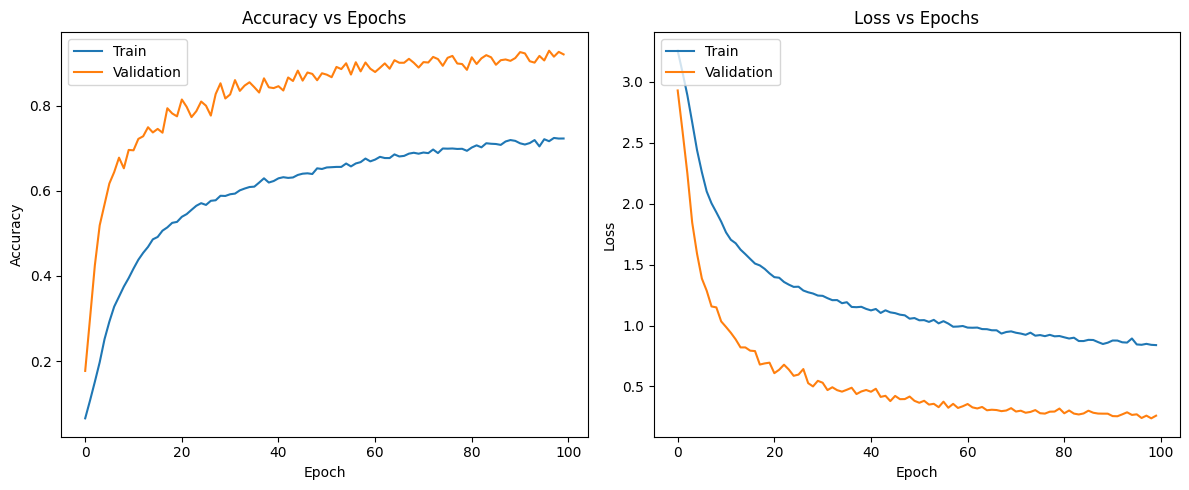

In [17]:
# evaluating the test set on the model
test_loss, test_accuracy = ahcr_model_aug.evaluate(test_images, test_labels)
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Loss: {test_loss}')

plotAccuracyLossVsEpochs(history=history_aug)

## **Task 3**

LeNet: One of the earliest convolutional neural networks, LeNet was designed mainly for handwritten and machine-printed character recognition. It's relatively small and simple, which makes it fast to train. However, it may not perform as well on more complex image recognition tasks compared to more modern architectures.

AlexNet: This model is significantly larger and more complex than LeNet. It was the first to use ReLU (Rectified Linear Units) for the nonlinear layers and performed exceptionally well in the ImageNet competition. AlexNet is more suitable for datasets that are more complex than those LeNet can handle, but it requires more computational power.

ResNet (Residual Network): Known for its "skip connections" or "shortcut connections," ResNet allows the training of very deep networks by addressing the vanishing gradient problem. It's much deeper than AlexNet and is currently one of the best performing models for a wide range of image recognition tasks. It's particularly beneficial for very deep networks and can handle a wide range of complex tasks. However, it requires significant computational resources.

Which One to Choose?
Task Complexity: For simple tasks or small datasets, LeNet can be sufficient. For medium complexity tasks, AlexNet is more suitable. For very complex tasks, ResNet is generally the best choice.

Computational Resources: LeNet and AlexNet are less demanding in terms of computational resources, while ResNet requires more substantial computing power, especially for deeper variants like ResNet-50 or ResNet-101.

Training Time: LeNet will train the fastest, followed by AlexNet. ResNet's training time is considerably longer due to its depth and complexity.

Performance: Generally, ResNet outperforms AlexNet, and AlexNet outperforms LeNet on complex image classification tasks.

Define CNN architecture

Create and compile the model

Train the model

Plot and print the result

# **Conclusion**